Modified to use just the BOCD, no multi-fidelity

In [1]:
from   matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
from   numpy.random import RandomState
from   scipy.stats import (beta as beta_dist,
                           bernoulli)

from   mfbocd.inference import (bocd)
from   mfbocd.models import Bernoulli

color_lf = '#e6550d'
color_hf = '#6baed6'


def gen_data(rng, n_samples, alpha0, beta0,cp_prob):
    curr_p = None
    params = np.empty(n_samples)
    cps    = []
    xs     = np.empty(n_samples)

    for t in range(0, n_samples):
        if curr_p is None or rng.uniform(0, 1) < cp_prob:
            curr_p = beta_dist(alpha0, beta0).rvs(size=1, random_state=rng)
            cps.append(t)

        params[t] = curr_p
        xs[t]  = bernoulli(curr_p).rvs(size=1, random_state=rng)

    return params, xs, cps


def plot_data(ax, params, data, mean, var, colors, markers):
    for mark in ['x', 'o']:
        inds = markers == mark
        xx   = np.where(markers == mark)
        yy   = data[inds]
        if mark == 'x':
            ax.scatter(xx, yy, c=colors[inds], s=20, marker=mark)
        else:
            ax.scatter(xx, yy, s=20, marker=mark, 
                       edgecolors=colors[inds],
                       facecolors='none')
            
    xx = range(0, len(data))
    ax.plot(xx, params, c='k', ls='--')
    ax.plot(xx, mean, c='k', alpha=0.5)
    _2std = 2 * np.sqrt(var)
    ax.plot(xx, mean - _2std, color='k', ls='--', alpha=0.5)
    ax.plot(xx, mean + _2std, color='k', ls='--', alpha=0.5)
    ax.margins(0)
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel(r'Data $\mathbf{x}_t$', fontsize=16)
        

def plot_posterior(ax, R, cps):
    T = len(R)-1
    lnorm = LogNorm(vmin=0.0001, vmax=1)
    ax.imshow(np.rot90(R), aspect='auto', cmap='gray_r', norm=lnorm)
    ax.set_xlim([0, T])
    # This just reverses the y-tick marks.
    ticks = list(range(0, T, 50))
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks[::-1])
    ax.set_ylabel(r'Run length $r_t$', fontsize=16)
    

def get_data_for_viz(inds):
    D = np.empty(T)
    M = []
    C = []
    for t in range(T):
        if inds[t] == 0:
            D[t] = xs[0, :][t]
            M.append('x')
            C.append(color_lf)
        else:
            assert(inds[t] == 1)
            D[t] = xs[1, :][t]
            M.append('o')
            C.append(color_hf)
    C = np.array(C)
    M = np.array(M)
    return D, C, M

## Generate data

In [2]:
alpha0   = 0.1
beta0    = 0.1
T        = 500 #number of samples
cp_prob  = 1./100
rng      = RandomState(seed=1)

params, xs, cps = gen_data(rng, T, alpha0, beta0, cp_prob)

## Run BOCD

In [3]:
model_simple = Bernoulli(T, alpha0, beta0)
out_model = bocd(xs, model_simple, cp_prob)

## Visualize results

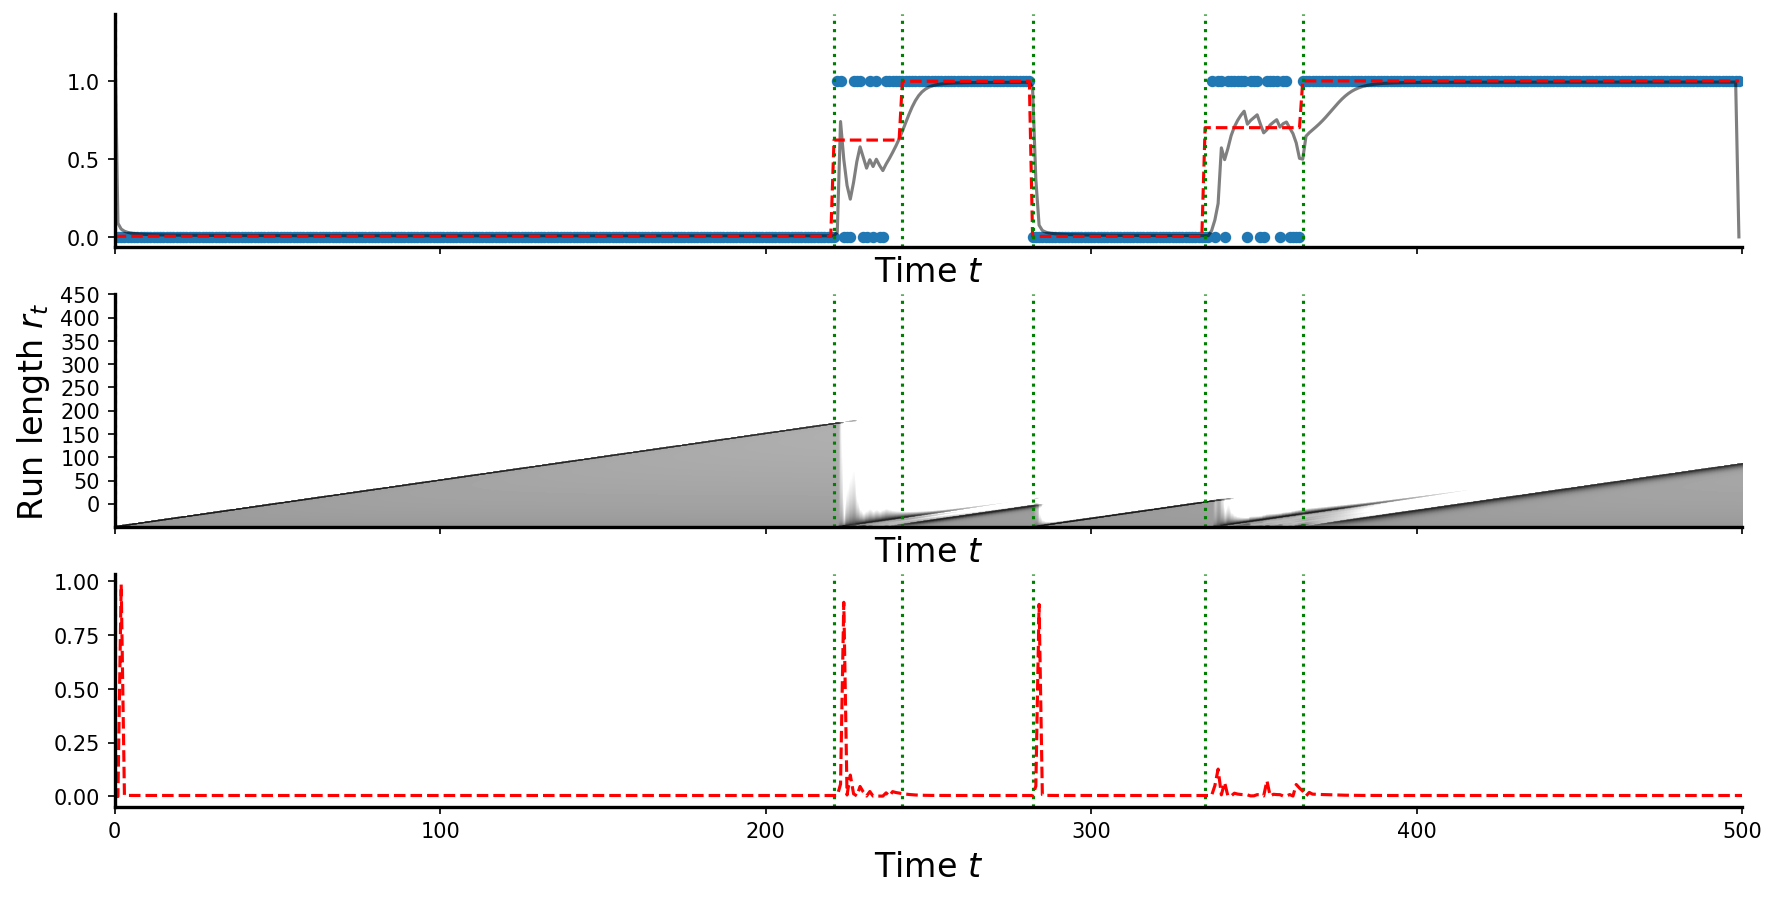

In [4]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(14, 7), dpi=150, sharex=True)
xx = range(0, T) #for the x axis

#first plot: the data and the inferred p
ax1.scatter(xx, xs, s=20, marker="o")
ax1.plot(xx, out_model._pmean, c='k', alpha=0.5) #model's est of parameter
ax1.plot(xx, params, c='r', ls='--') #true parameter

#second: posterior over the run length (posterior is ntrials x ntrials, since on last trial, maintain possibility that there was just one single run)
LenR = len(model_simple._R)-1
lnorm = LogNorm(vmin=0.0001, vmax=1) #?
ax2.imshow(np.rot90(model_simple._R), aspect='auto', cmap='gray_r', norm=lnorm)
ax2.set_xlim([0, LenR])
# This just reverses the y-tick marks.
ticks = list(range(0, LenR, 50))
ax2.set_yticks(ticks)
ax2.set_yticklabels(ticks[::-1])
ax2.set_ylabel(r'Run length $r_t$', fontsize=16)

for ax in [ax1, ax2,ax3]:
    for cp in cps:
        ax.axvline(cp, c='g', ls='dotted')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(r'Time $t$', fontsize=16)
    [i.set_linewidth(1.6) for i in ax.spines.values()]

#final: change-point, as p(r=0)
est_r0 = model_simple._R[:,2] #I'm just trying... not sure if they work; 1 & 2 somehow has the peaks??? Because people only become sure of CP after a few observations, in Bernoulli?
ax3.plot(range(0,len(est_r0)), est_r0 , c='r', ls='--') #true parameter

Export to compare in MATLAB

In [7]:
# import h5py
# # Specify the file path where you want to save the data
# hdf5_file_path = 'PracticeBOCD/python_out2compare.h5'

# # Create an HDF5 file
# with h5py.File(hdf5_file_path, 'w') as hdf5_file:
#     # Save the variables as datasets in the HDF5 file
#     hdf5_file.create_dataset('params', data=params)
#     hdf5_file.create_dataset('xs', data=xs)
#     hdf5_file.create_dataset('cps', data=cps)
#     hdf5_file.create_dataset('est_p', data=out_model._pmean)
#     hdf5_file.create_dataset('theR', data=model_simple._R)

# Specify the file paths where you want to save the data
params_file_path = 'MATLABversion/python_out2compare/params.csv'
xs_file_path = 'MATLABversion/python_out2compare/xs.csv'
cps_file_path = 'MATLABversion/python_out2compare/cps.csv'
est_p_file_path = 'MATLABversion/python_out2compare/est_p.csv'
theR_file_path = 'MATLABversion/python_out2compare/the_R.csv'

# Save the variables to CSV files
np.savetxt(params_file_path, params, delimiter=',')
np.savetxt(xs_file_path, xs, delimiter=',')
np.savetxt(cps_file_path, cps, delimiter=',')
np.savetxt(est_p_file_path, out_model._pmean, delimiter=',')
np.savetxt(theR_file_path, model_simple._R, delimiter=',')

In [11]:
print(out_model._pmean[0:9])
print(model_simple._R[0:5,0:5])

[1.35914091 0.0875     0.05020548 0.03628256 0.02902121 0.02457154
 0.02156969 0.01941049 0.01778445]
[[2.71828183 0.         0.         0.         0.        ]
 [0.01       0.99       0.         0.         0.        ]
 [0.01       0.00542466 0.98457534 0.         0.        ]
 [0.01       0.00521165 0.0051831  0.97960525 0.        ]
 [0.01       0.00513636 0.00490764 0.00508243 0.97487357]]
